In [0]:
from google.colab import auth
auth.authenticate_user()

##Topic Modeling with TFIDF

In [0]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import csv, sys
import pandas as pd
import xgboost
import numpy as np
import textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
!mkdir data_topic
!gsutil cp -r gs://qatar_competition/data_topic ./

Copying gs://qatar_competition/data_topic/dev.tsv...
Copying gs://qatar_competition/data_topic/train.tsv...
- [2 files][317.0 KiB/317.0 KiB]                                                
Operation completed over 2 objects/317.0 KiB.                                    


In [0]:
# load the dataset
def read_tsv(input_file, quotechar=None):
  with open(input_file, "r", encoding="utf-8-sig") as f:
    reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
    lines = []
    for line in reader:
      if sys.version_info[0] == 2:
        line = list(unicode(cell, 'utf-8') for cell in line)
      lines.append(line)
    return lines

# create a dataframe using texts and lables
trainDF = pd.DataFrame(read_tsv("./data_topic/train.tsv"))
df_train = pd.DataFrame([],columns=["text","label"])
df_train["text"]=trainDF[3]
df_train["label"]=trainDF[1]

testDF = pd.DataFrame(read_tsv("./data_topic/dev.tsv"))
df_test = pd.DataFrame([],columns=["text","label"])
df_test["text"]=testDF[3]
df_test["label"]=testDF[1]

In [0]:
print(df_train.head())
print(df_test.head())

                                                text label
0  White House battles Clintons in Communist ties...     3
1  Phone device tests male fertility with 98% acc...     5
2  "Doping Levels Surprisingly Low, Finds Sports ...     4
3  "Michelle Pfeiffer says she's 'looking towards...     2
4  "New intelligence suggests ISIS rigging laptop...     5
                                                text label
0  Super Mario Run makes leap to Android  The wil...     5
1  "Trump calls Democrats 'losers' after GOP heal...     3
2  "Brexit talks will fail without compromise: Jo...     0
3  " Indian Wells: Roger Federer beats Stan Wawri...     4
4  "Stan Wawrinka proves victorious of Roger Fede...     4


In [0]:
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()
def remove_stopwords(words):
    filtered_words = []
    for word in words:
        if word not in stop_words:
            filtered_words.append(word)            
    return filtered_words

def remove_punctuation(words):
  words_cleaned =[]
  for word in words:
    if word.isalpha():# ."isalpha() checks whether the string consists of alphabetic characters only.
      words_cleaned.append(word)
   
  return words_cleaned

def cleaning(s):
    
    s = str(s)
    #s = str.split(s)
    s = s.lower()
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub(r'[^\w]', ' ', s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace(",","")
    s = s.replace("[\w*"," ")
    s = re.sub(r'https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
    s = re.sub(r'\<a href', ' ', s)
    s = re.sub(r'&amp;', '', s) 
    s = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', s)
    s = re.sub(r'[^\x00-\x7f]',r'',s) #removes arabic
    s = re.sub(r'<br />', ' ', s)
    s = re.sub(r'\'', ' ', s)
    
    return s

In [0]:
df_train_cleaned = pd.DataFrame([],columns=["text","label"])
df_train_cleaned["text"] = df_train["text"].apply(str.lower)
print(df_train_cleaned.head())
df_train_cleaned["text"] = df_train_cleaned["text"].apply(nltk.word_tokenize)
print(df_train_cleaned.head())
#df_train_cleaned["text"] = df_train_cleaned["text"].apply(lambda x: [lemma.lemmatize(i) for i in x])
print(df_train_cleaned.head())
df_train_cleaned["text"] = df_train_cleaned["text"].apply(remove_stopwords)
print(df_train_cleaned.head())
df_train_cleaned["text"] = df_train_cleaned["text"].apply(remove_punctuation).apply(lambda x: ' '.join(word for word in x))
print(df_train_cleaned.head())

df_test_cleaned = pd.DataFrame([],columns=["text","label"])
df_test_cleaned["text"] = df_test["text"].apply(str.lower)
print(df_test_cleaned.head())
df_test_cleaned["text"] = df_test_cleaned["text"].apply(nltk.word_tokenize)
print(df_test_cleaned.head())
#df_test_cleaned["text"] = df_test_cleaned["text"].apply(lambda x: [lemma.lemmatize(i) for i in x])
print(df_test_cleaned.head())
df_test_cleaned["text"] = df_test_cleaned["text"].apply(remove_stopwords)
print(df_test_cleaned.head())
df_test_cleaned["text"] = df_test_cleaned["text"].apply(remove_punctuation).apply(lambda x: ' '.join(word for word in x))
print(df_test_cleaned.head())

                                                text label
0  white house battles clintons in communist ties...   NaN
1  phone device tests male fertility with 98% acc...   NaN
2  "doping levels surprisingly low, finds sports ...   NaN
3  "michelle pfeiffer says she's 'looking towards...   NaN
4  "new intelligence suggests isis rigging laptop...   NaN
                                                text label
0  [white, house, battles, clintons, in, communis...   NaN
1  [phone, device, tests, male, fertility, with, ...   NaN
2  [``, doping, levels, surprisingly, low, ,, fin...   NaN
3  [``, michelle, pfeiffer, says, she, 's, 'looki...   NaN
4  [``, new, intelligence, suggests, isis, riggin...   NaN
                                                text label
0  [white, house, battles, clintons, in, communis...   NaN
1  [phone, device, tests, male, fertility, with, ...   NaN
2  [``, doping, levels, surprisingly, low, ,, fin...   NaN
3  [``, michelle, pfeiffer, says, she, 's, 'looki...   N

In [0]:
df_train_cleaned = pd.DataFrame([],columns=["text","label"])
df_train_cleaned["text"] = df_train["text"].apply(cleaning)
print(df_train_cleaned.head())
df_train_cleaned["text"] = df_train_cleaned["text"].apply(nltk.word_tokenize)
print(df_train_cleaned.head())
#df_train_cleaned["text"] = df_train_cleaned["text"].apply(lambda x: [lemma.lemmatize(i) for i in x])
print(df_train_cleaned.head())
df_train_cleaned["text"] = df_train_cleaned["text"].apply(remove_stopwords).apply(lambda x: ' '.join(word for word in x))
print(df_train_cleaned.head())



df_test_cleaned = pd.DataFrame([],columns=["text","label"])
df_test_cleaned["text"] = df_test["text"].apply(cleaning)
print(df_test_cleaned.head())
df_test_cleaned["text"] = df_test_cleaned["text"].apply(nltk.word_tokenize)
print(df_test_cleaned.head())
#df_test_cleaned["text"] = df_test_cleaned["text"].apply(lambda x: [lemma.lemmatize(i) for i in x])
print(df_test_cleaned.head())
df_test_cleaned["text"] = df_test_cleaned["text"].apply(remove_stopwords).apply(lambda x: ' '.join(word for word in x))
print(df_test_cleaned.head())

                                                text label
0  white house battles clintons in communist ties...   NaN
1  phone device tests male fertility with accurac...   NaN
2   doping levels surprisingly low finds sports m...   NaN
3   michelle pfeiffer says she s looking towards ...   NaN
4   new intelligence suggests isis rigging laptop...   NaN
                                                text label
0  [white, house, battles, clintons, in, communis...   NaN
1  [phone, device, tests, male, fertility, with, ...   NaN
2  [doping, levels, surprisingly, low, finds, spo...   NaN
3  [michelle, pfeiffer, says, she, s, looking, to...   NaN
4  [new, intelligence, suggests, isis, rigging, l...   NaN
                                                text label
0  [white, house, battles, clintons, in, communis...   NaN
1  [phone, device, tests, male, fertility, with, ...   NaN
2  [doping, levels, surprisingly, low, finds, spo...   NaN
3  [michelle, pfeiffer, says, she, s, looking, to...   N

In [0]:
df_train_cleaned["label"]= df_train["label"]
df_test_cleaned["label"]= df_test["label"]

In [0]:
df_train_cleaned['text'][295]

'foods supersize production burger easy sink teeth one impossible foods meatless hamburgers get eight us restaurants wednesday though company said bring impossible burger eateries year end make happen firm opening factory size city block goal make least million pounds faux burger meat every month think birthplace whole new industry going transform food system said pat brown former stanford biochemistry professor founded impossible foods serves ceo'

##Count Vector as Features

In [0]:
# create a count vectorizer object 
all_data = df_train_cleaned["text"].append(df_test_cleaned["text"])
train_x = df_train_cleaned["text"].tolist()
valid_x = df_test_cleaned["text"].tolist()
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(all_data)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

In [0]:
xtrain_count

<384x7148 sparse matrix of type '<class 'numpy.int64'>'
	with 22390 stored elements in Compressed Sparse Row format>

In [0]:
xvalid_count

<48x7148 sparse matrix of type '<class 'numpy.int64'>'
	with 2755 stored elements in Compressed Sparse Row format>

In [0]:
xtrain_count_df=pd.DataFrame(xvalid_count.toarray(), columns=count_vect.get_feature_names())
xtrain_count_df.head()

,aapl,aback,abandon,abc,abdullah,ability,able,abortion,abroad,absence,absent,absolutely,absurd,absurdity,abundant,abundantly,abuse,abusing,abusive,academic,academically,academy,accelerates,accent,accept,acceptance,accepted,accepting,accepts,access,accessible,accessory,accident,accommodate,accompanied,accompanying,accomplish,accomplishment,according,account,...,wrestler,wrist,writedown,writer,writing,written,wrong,wrote,wwe,xenon,ya,yahoo,yale,yamaha,yard,yardsale,year,yell,yellow,yen,yes,yesterday,yet,yield,yielded,york,young,younger,youngest,youth,youtube,z,zack,zaha,zeballos,zero,zipping,zombie,zuckerberg,zverev
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##TF-IDF as Features

In [0]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=None)
tfidf_vect.fit(all_data)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,4), max_features=8000)
tfidf_vect_ngram.fit(all_data)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(1,6), max_features=8000)
tfidf_vect_ngram_chars.fit(all_data)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

from scipy.sparse import hstack
# stacked Char level and word ngram
xtrain_tfidf_ngram_chars_words = hstack([xtrain_tfidf_ngram,xtrain_tfidf_ngram_chars])
xvalid_tfidf_ngram_chars_words = hstack([xvalid_tfidf_ngram,xvalid_tfidf_ngram_chars])

In [0]:
print(xtrain_tfidf_ngram.shape)
print(xtrain_tfidf_ngram_chars.shape)
print(xtrain_tfidf_ngram_chars_words.shape)

(384, 8000)
(384, 8000)
(384, 16000)


In [0]:
xtrain_tfidf_df=pd.DataFrame(xtrain_tfidf.toarray(), columns=tfidf_vect.get_feature_names())
xtrain_tfidf_df.head()

,aapl,aback,abandon,abc,abdullah,abilities,ability,able,abortion,abroad,absence,absent,absolutely,absurd,absurdity,abundant,abundantly,abuse,abusing,abusive,academic,academically,academy,accelerates,accent,accept,acceptance,accepted,accepting,accepts,access,accessible,accessories,accessory,accident,accidents,accommodate,accompanied,accompanying,accomplish,...,writedown,writer,writing,written,wrong,wrote,wwe,xenon,ya,yahoo,yale,yamaha,yard,yards,yardsale,year,years,yell,yellow,yen,yes,yesterday,yet,yield,yielded,york,young,younger,youngest,youth,youtube,z,zack,zaha,zeballos,zero,zipping,zombie,zuckerberg,zverev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.064936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142664,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.063454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045106,0.044176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##Pre_trained Embeddings

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip crawl-300d-2M.vec.zip

--2019-09-27 15:49:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.6.166, 104.20.22.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.6.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  13.6MB/s    in 1m 49s  

2019-09-27 15:50:58 (13.3 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [0]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('crawl-300d-2M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(all_data)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=144)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=144)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [0]:
max=0
for i ,sent in enumerate(token.texts_to_sequences(train_x)):
  if len(sent)>max:
    max=len(sent)
  if len(sent)>140:
    print(i)

print(max)

88
144


In [0]:
embedding_matrix.shape

(6983, 300)

In [0]:
len(word_index.items())

6982

##Topic Models as features

In [0]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [0]:
X_topics.shape

(384, 20)

##Model Building

In [0]:
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy 
from sklearn.metrics import precision_score, recall_score , f1_score , classification_report,precision_recall_fscore_support,accuracy_score
import keras as keras

class Metrix(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(classifier.predict(X_val))
        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict,average='weighted'),
            'val_precision': precision_score(y_val, y_predict,average='weighted'),
            'val_f1': f1_score(y_val, y_predict,average='weighted')
        })
        return

    def get_data(self):
        return self._data


def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False , epochs=1, show_report=True, print_pred=False,one_hot=False):
    # fit the training dataset on the classifier
    if one_hot:
      label = to_categorical(label)
    if is_neural_net:
      
      history = classifier.fit(feature_vector_train,label,epochs=epochs, validation_data=(feature_vector_valid, to_categorical(valid_y)), callbacks=[mtrix])
    else:
      classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    if print_pred:
      print(predictions)
    if show_report:
      print(classification_report(valid_y,predictions))
    if is_neural_net:
      return accuracy_score(valid_y, predictions) , precision_recall_fscore_support(valid_y,predictions) , history
    else:
      return accuracy_score(valid_y, predictions) , precision_recall_fscore_support(valid_y,predictions)

train_y = df_train_cleaned["label"].apply(int).tolist()
valid_y  = df_test_cleaned["label"].apply(int).tolist()

##Naive Bayes

In [0]:
# Naive Bayes on Count Vectors
accuracy , prfs = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count,print_pred=True)
print ("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy , prfs = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy , prfs = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy , prfs = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

# Naive Bayes on Character Level and word TF IDF Vectors
accuracy , prfs = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars_words, train_y, xvalid_tfidf_ngram_chars_words)
print ("NB, CharLevel Vectors and N-Gram: ", accuracy)

[5 3 0 4 4 4 0 1 0 0 5 4 3 2 1 5 1 4 2 2 1 3 5 4 1 3 5 2 5 5 5 3 0 0 4 3 0
 5 1 4 5 4 5 1 3 1 3 0]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       1.00      1.00      1.00         8
           2       0.75      0.38      0.50         8
           3       1.00      1.00      1.00         8
           4       0.78      0.88      0.82         8
           5       0.64      0.88      0.74         8

    accuracy                           0.77        48
   macro avg       0.78      0.77      0.76        48
weighted avg       0.78      0.77      0.76        48

NB, Count Vectors:  0.7708333333333334
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       1.00      1.00      1.00         8
           2       0.75      0.38      0.50         8
           3       1.00      1.00      1.00         8
           4       0.78      0.88      0.82     

##Linear Classifier

In [0]:
# Linear Classifier on Count Vectors
accuracy , prfs = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count,print_pred=True)
print ("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy , prfs = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy , prfs = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy , prfs = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy , prfs = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars_words, train_y, xvalid_tfidf_ngram_chars_words)
print ("LR, CharLevel Vectors: ", accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[4 3 0 4 4 4 0 1 0 0 4 4 3 2 1 5 1 4 2 2 3 3 5 4 1 3 5 2 5 5 5 3 0 0 4 3 0
 5 1 4 5 4 5 1 3 1 3 0]
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       1.00      0.88      0.93         8
           2       0.75      0.38      0.50         8
           3       0.89      1.00      0.94         8
           4       0.64      0.88      0.74         8
           5       0.67      0.75      0.71         8

    accuracy                           0.73        48
   macro avg       0.74      0.73      0.72        48
weighted avg       0.74      0.73      0.72        48

LR, Count Vectors:  0.7291666666666666
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         8
           1       1.00      0.88      0.93         8
           2       0.75      0.38      0.50         8
           3       0.89      1.00      0.94         8
           4       0.70      0.88      0.78     

##SVM

In [0]:
# SVM on Ngram Level TF IDF Vectors
accuracy , prfs = train_model(svm.SVC(kernel='rbf',decision_function_shape ='ovo',cache_size=1024), xtrain_tfidf_ngram_chars_words, train_y, xvalid_tfidf_ngram_chars_words,print_pred=True)
print ("SVM, N-Gram Vectors: ", accuracy)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[5 3 0 4 2 4 2 1 0 0 2 4 3 2 1 5 1 2 2 2 3 3 2 4 1 3 5 2 5 5 2 3 2 0 2 3 0
 2 1 4 2 2 5 2 3 1 3 0]
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       1.00      0.75      0.86         8
           2       0.38      0.75      0.50         8
           3       0.89      1.00      0.94         8
           4       0.80      0.50      0.62         8
           5       0.67      0.50      0.57         8

    accuracy                           0.67        48
   macro avg       0.73      0.67      0.68        48
weighted avg       0.73      0.67      0.68        48

SVM, N-Gram Vectors:  0.6666666666666666


##Bagging Model

In [0]:
# RF on Count Vectors
accuracy , prfs = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count,print_pred=True)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy , prfs = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print("RF, WordLevel TF-IDF: ", accuracy)

[5 3 0 4 4 4 5 1 0 0 5 4 3 2 1 5 1 4 2 2 3 3 1 5 1 3 5 2 5 5 5 3 2 0 4 3 5
 4 1 1 5 1 0 1 3 1 3 0]
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.70      0.88      0.78         8
           2       0.80      0.50      0.62         8
           3       0.89      1.00      0.94         8
           4       0.86      0.75      0.80         8
           5       0.45      0.62      0.53         8

    accuracy                           0.69        48
   macro avg       0.70      0.69      0.68        48
weighted avg       0.70      0.69      0.68        48

RF, Count Vectors:  0.6875
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       1.00      0.75      0.86         8
           2       0.00      0.00      0.00         8
           3       0.89      1.00      0.94         8
           4       0.41      0.88      0.56         8
      

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##Boosting Model

In [0]:
# Extereme Gradient Boosting on Count Vectors
accuracy , prfs = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc(),print_pred=True)
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy , prfs = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy , prfs = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars_words.tocsc(), train_y, xvalid_tfidf_ngram_chars_words.tocsc())
print("Xgb, CharLevel Vectors: ", accuracy)

[5 3 0 4 4 4 0 1 0 2 0 4 3 2 1 4 1 4 2 2 3 3 5 5 1 3 5 0 5 5 1 3 2 0 4 3 0
 5 1 2 0 4 5 0 3 1 3 0]
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.86      0.75      0.80         8
           2       0.67      0.50      0.57         8
           3       0.89      1.00      0.94         8
           4       0.75      0.75      0.75         8
           5       0.75      0.75      0.75         8

    accuracy                           0.75        48
   macro avg       0.75      0.75      0.75        48
weighted avg       0.75      0.75      0.75        48

Xgb, Count Vectors:  0.75
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.86      0.75      0.80         8
           2       0.80      0.50      0.62         8
           3       0.89      1.00      0.94         8
           4       0.70      0.88      0.78         8
       

##Shallow Neural Network

In [0]:
def create_model_architecture(input_size,num_layers=1):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(1000, activation="relu")(input_layer)

    if num_layers>1:
      for i in range(num_layers-1):
        hidden_layer = layers.Dense(int(1000/(10*i+1)), activation="relu")(hidden_layer)
        Dropout_layer = layers.Dropout(0.05)(hidden_layer)
    
    # create output layer
    output_layer = layers.Dense(6, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=[categorical_accuracy])
    return classifier 


In [0]:
classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
mtrix=Metrix() 
accuracy , prfs , history = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True,epochs=10,print_pred=True,one_hot=True)
print("NN, Ngram Level TF IDF Vectors",  accuracy)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 384 samples, validate on 48 samples
Epoch 1/10
384/384 [==============================] - 7s 19ms/step - loss: 0.6660 - categorical_accuracy: 0.4818 - val_loss: 0.6361 - val_categorical_accuracy: 0.4375
Epoch 2/10
 96/384 [======>.......................] - ETA: 0s - loss: 0.5375 - categorical_accuracy: 1.0000

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


384/384 [==============================] - 1s 2ms/step - loss: 0.4724 - categorical_accuracy: 1.0000 - val_loss: 0.5435 - val_categorical_accuracy: 0.4792
Epoch 3/10
384/384 [==============================] - 1s 2ms/step - loss: 0.3107 - categorical_accuracy: 1.0000 - val_loss: 0.4857 - val_categorical_accuracy: 0.4792
Epoch 4/10
384/384 [==============================] - 1s 2ms/step - loss: 0.1918 - categorical_accuracy: 1.0000 - val_loss: 0.4673 - val_categorical_accuracy: 0.5000
Epoch 5/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0933 - categorical_accuracy: 1.0000 - val_loss: 0.4476 - val_categorical_accuracy: 0.5625
Epoch 6/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0435 - categorical_accuracy: 1.0000 - val_loss: 0.4284 - val_categorical_accuracy: 0.5833
Epoch 7/10
384/384 [==============================] - 1s 2ms/step - loss: 0.0221 - categorical_accuracy: 1.0000 - val_loss: 0.4186 - val_categorical_accuracy: 0.5833
Epoch 8/10
384/

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


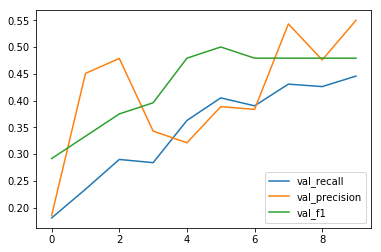

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

In [0]:
mtrix.get_data()

[{'val_f1': 0.18080808080808083,
  'val_precision': 0.18568627450980393,
  'val_recall': 0.2916666666666667},
 {'val_f1': 0.23435281971867336,
  'val_precision': 0.45066045066045063,
  'val_recall': 0.3333333333333333},
 {'val_f1': 0.2900027847396269,
  'val_precision': 0.47860962566844917,
  'val_recall': 0.375},
 {'val_f1': 0.28398692810457515,
  'val_precision': 0.3429487179487179,
  'val_recall': 0.3958333333333333},
 {'val_f1': 0.36279942279942273,
  'val_precision': 0.32110536522301225,
  'val_recall': 0.4791666666666667},
 {'val_f1': 0.4050039872408293,
  'val_precision': 0.388560606060606,
  'val_recall': 0.5},
 {'val_f1': 0.3901272789817682,
  'val_precision': 0.3835331335331335,
  'val_recall': 0.4791666666666667},
 {'val_f1': 0.4306882071825146,
  'val_precision': 0.5431188175753393,
  'val_recall': 0.4791666666666667},
 {'val_f1': 0.4260504201680672,
  'val_precision': 0.4758852258852258,
  'val_recall': 0.4791666666666667},
 {'val_f1': 0.44566514566514565,
  'val_precision

##Deep Neural Networks

In [0]:
classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1],num_layers=5)
mtrix=Metrix() 
accuracy , prfs , history = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True,epochs=40,print_pred=True,one_hot=True)

print("DN, Ngram Level TF IDF Vectors",  accuracy)

Train on 384 samples, validate on 48 samples
Epoch 1/40
384/384 [==============================] - 14s 36ms/step - loss: 0.6292 - categorical_accuracy: 0.1693 - val_loss: 0.4936 - val_categorical_accuracy: 0.1667


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/40
384/384 [==============================] - 8s 21ms/step - loss: 0.5013 - categorical_accuracy: 0.2370 - val_loss: 0.5772 - val_categorical_accuracy: 0.1667
Epoch 3/40
384/384 [==============================] - 8s 20ms/step - loss: 0.4230 - categorical_accuracy: 0.4922 - val_loss: 0.4841 - val_categorical_accuracy: 0.3333
Epoch 4/40
384/384 [==============================] - 8s 20ms/step - loss: 0.2798 - categorical_accuracy: 0.5495 - val_loss: 0.4443 - val_categorical_accuracy: 0.3542
Epoch 5/40
384/384 [==============================] - 8s 20ms/step - loss: 0.1764 - categorical_accuracy: 0.7266 - val_loss: 0.4539 - val_categorical_accuracy: 0.2083
Epoch 6/40
384/384 [==============================] - 8s 20ms/step - loss: 0.0605 - categorical_accuracy: 0.9688 - val_loss: 0.4622 - val_categorical_accuracy: 0.3750
Epoch 7/40
384/384 [==============================] - 8s 21ms/step - loss: 0.0055 - categorical_accuracy: 1.0000 - val_loss: 0.5742 - val_categorical_accuracy: 0.354

KeyboardInterrupt: ignored

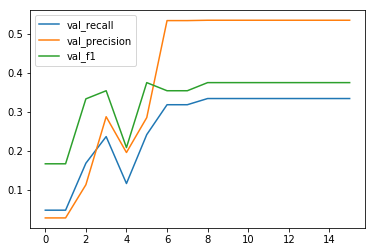

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

##CNN

In [0]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((144, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    #embedding_layer = layers.SpatialDropout1D(0)(embedding_layer)
    #print(embedding_layer)
    #embedding_layer = layers.Reshape((300,144))(embedding_layer)
    #print(embedding_layer)
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(256, 5, activation="relu")(embedding_layer)

    pooling_layer = layers.MaxPooling1D(2)(conv_layer)

    conv_layer2 = layers.Convolution1D(64, 5, activation="relu")(pooling_layer)
    
    pooling_layer2 = layers.MaxPooling1D(2)(conv_layer2)

    #conv_layer3 = layers.Convolution1D(128, 5, activation="relu")(pooling_layer2)
    
    #pooling_layer3 = layers.MaxPooling1D(35)(conv_layer3)
    l_flat = layers.Flatten()(conv_layer2)
    # Add the output Layers
    output_layer1 = layers.Dense(64, activation="relu")(l_flat)
    output_layer1 = layers.Dropout(0.1)(output_layer1)
    output_layer2 = layers.Dense(6, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=[categorical_accuracy])
    
    return model

classifier = create_cnn()
mtrix=Metrix()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=40,print_pred=False,one_hot=True)
print("CNN, Word Embeddings",  accuracy)

Train on 384 samples, validate on 48 samples
Epoch 1/40
384/384 [==============================] - 4s 10ms/step - loss: 0.4944 - categorical_accuracy: 0.2500 - val_loss: 0.4257 - val_categorical_accuracy: 0.2292
Epoch 2/40
384/384 [==============================] - 0s 507us/step - loss: 0.3486 - categorical_accuracy: 0.5651 - val_loss: 0.3463 - val_categorical_accuracy: 0.5208


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 3/40
384/384 [==============================] - 0s 489us/step - loss: 0.2044 - categorical_accuracy: 0.8177 - val_loss: 0.2741 - val_categorical_accuracy: 0.6042
Epoch 4/40
384/384 [==============================] - 0s 487us/step - loss: 0.0989 - categorical_accuracy: 0.9531 - val_loss: 0.2672 - val_categorical_accuracy: 0.6458
Epoch 5/40
384/384 [==============================] - 0s 463us/step - loss: 0.0471 - categorical_accuracy: 0.9818 - val_loss: 0.3009 - val_categorical_accuracy: 0.7500
Epoch 6/40
384/384 [==============================] - 0s 487us/step - loss: 0.0235 - categorical_accuracy: 0.9922 - val_loss: 0.2998 - val_categorical_accuracy: 0.7292
Epoch 7/40
384/384 [==============================] - 0s 479us/step - loss: 0.0109 - categorical_accuracy: 1.0000 - val_loss: 0.3237 - val_categorical_accuracy: 0.7083
Epoch 8/40
384/384 [==============================] - 0s 479us/step - loss: 0.0056 - categorical_accuracy: 1.0000 - val_loss: 0.2681 - val_categorical_accuracy:

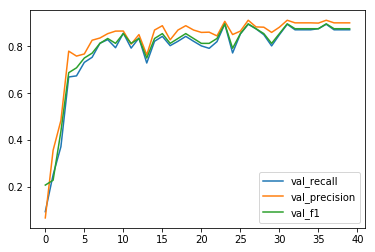

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

In [0]:
model_json = classifier.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
classifier.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [0]:
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=[categorical_accuracy])
score = loaded_model.evaluate(valid_seq_x, to_categorical(valid_y), verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

48/48 [==============================] - 3s 55ms/step
categorical_accuracy: 85.42%


In [0]:
!gsutil cp model.h5 gs://qatar_competition/Topic_CNN/
!gsutil cp model.json gs://qatar_competition/Topic_CNN/

Copying file://model.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/7.7 MiB.                                      
Copying file://model.json [Content-Type=application/json]...
/ [1 files][  3.1 KiB/  3.1 KiB]                                                
Operation completed over 1 objects/3.1 KiB.                                      


##LSTM

In [0]:
def create_rnn_lstm(input_length,):
    # Add an Input Layer
    input_layer = layers.Input((input_length, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(500)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.05)(output_layer1)
    output_layer2 = layers.Dense(6, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=[categorical_accuracy])
    
    return model

classifier = create_rnn_lstm(len(train_seq_x[0]))
mtrix=Metrix()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=50,print_pred=True,one_hot=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)

Train on 384 samples, validate on 48 samples
Epoch 1/50
384/384 [==============================] - 7s 18ms/step - loss: 0.5200 - categorical_accuracy: 0.2083 - val_loss: 0.4477 - val_categorical_accuracy: 0.3125


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/50
384/384 [==============================] - 4s 10ms/step - loss: 0.4331 - categorical_accuracy: 0.2865 - val_loss: 0.4309 - val_categorical_accuracy: 0.3333
Epoch 3/50
384/384 [==============================] - 4s 10ms/step - loss: 0.3897 - categorical_accuracy: 0.4479 - val_loss: 0.3649 - val_categorical_accuracy: 0.5833
Epoch 4/50
384/384 [==============================] - 4s 10ms/step - loss: 0.3239 - categorical_accuracy: 0.6120 - val_loss: 0.3304 - val_categorical_accuracy: 0.5417
Epoch 5/50
384/384 [==============================] - 4s 10ms/step - loss: 0.2545 - categorical_accuracy: 0.7083 - val_loss: 0.2847 - val_categorical_accuracy: 0.6667
Epoch 6/50
384/384 [==============================] - 4s 10ms/step - loss: 0.2382 - categorical_accuracy: 0.7240 - val_loss: 0.3864 - val_categorical_accuracy: 0.5625
Epoch 7/50
384/384 [==============================] - 4s 10ms/step - loss: 0.2595 - categorical_accuracy: 0.6927 - val_loss: 0.3240 - val_categorical_accuracy: 0.625

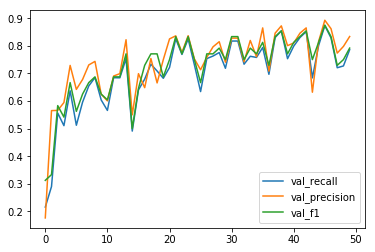

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

153

##GRU

In [0]:
def create_rnn_gru(input_length,):
    # Add an Input Layer
    input_layer = layers.Input((input_length, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    #embedding_layer = layers.SpatialDropout1D(0.1)(embedding_layer)

    # Add the GRU Layer
    lstm_layer = layers.GRU(200)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(100, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.1)(output_layer1)
    output_layer2 = layers.Dense(6, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=[categorical_accuracy])
    
    return model

classifier = create_rnn_gru(len(train_seq_x[0]))
mtrix=Metrics()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=40,print_pred=True,one_hot=True)
print( "RNN-GRU, Word Embeddings",  accuracy)

Train on 384 samples, validate on 48 samples
Epoch 1/40
384/384 [==============================] - 8s 21ms/step - loss: 0.5707 - categorical_accuracy: 0.1771 - val_loss: 0.4744 - val_categorical_accuracy: 0.1875


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/40
384/384 [==============================] - 3s 9ms/step - loss: 0.4554 - categorical_accuracy: 0.2318 - val_loss: 0.4507 - val_categorical_accuracy: 0.2500
Epoch 3/40
384/384 [==============================] - 3s 9ms/step - loss: 0.4349 - categorical_accuracy: 0.3828 - val_loss: 0.4423 - val_categorical_accuracy: 0.2708
Epoch 4/40
384/384 [==============================] - 3s 9ms/step - loss: 0.4152 - categorical_accuracy: 0.5104 - val_loss: 0.4329 - val_categorical_accuracy: 0.3958
Epoch 5/40
384/384 [==============================] - 3s 9ms/step - loss: 0.3893 - categorical_accuracy: 0.5677 - val_loss: 0.4167 - val_categorical_accuracy: 0.3750
Epoch 6/40
384/384 [==============================] - 3s 9ms/step - loss: 0.3292 - categorical_accuracy: 0.6354 - val_loss: 0.3555 - val_categorical_accuracy: 0.5208
Epoch 7/40
384/384 [==============================] - 3s 9ms/step - loss: 0.2925 - categorical_accuracy: 0.6328 - val_loss: 0.4084 - val_categorical_accuracy: 0.3958
Epoc

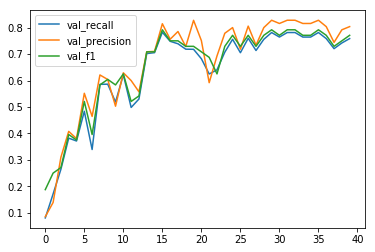

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

##Bidirectional RNN

In [0]:
def create_bidirectional_rnn():
    # Add an Input Layer
    input_layer = layers.Input((144, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    #embedding_layer = layers.SpatialDropout1D(0)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.LSTM(200))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.05)(output_layer1)
    output_layer2 = layers.Dense(6, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=[categorical_accuracy])
    
    return model

classifier = create_bidirectional_rnn()
mtrix=Metrix()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=40,print_pred=True,one_hot=True)
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

Train on 384 samples, validate on 48 samples
Epoch 1/40
384/384 [==============================] - 12s 30ms/step - loss: 0.5585 - categorical_accuracy: 0.1875 - val_loss: 0.4604 - val_categorical_accuracy: 0.2500


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/40
384/384 [==============================] - 8s 20ms/step - loss: 0.4549 - categorical_accuracy: 0.1823 - val_loss: 0.4500 - val_categorical_accuracy: 0.1667
Epoch 3/40
384/384 [==============================] - 8s 20ms/step - loss: 0.4416 - categorical_accuracy: 0.2760 - val_loss: 0.4417 - val_categorical_accuracy: 0.2708
Epoch 4/40
384/384 [==============================] - 7s 19ms/step - loss: 0.4189 - categorical_accuracy: 0.4844 - val_loss: 0.4100 - val_categorical_accuracy: 0.5000
Epoch 5/40
384/384 [==============================] - 8s 20ms/step - loss: 0.3715 - categorical_accuracy: 0.5182 - val_loss: 0.3799 - val_categorical_accuracy: 0.5625
Epoch 6/40
384/384 [==============================] - 8s 20ms/step - loss: 0.3418 - categorical_accuracy: 0.5781 - val_loss: 0.3823 - val_categorical_accuracy: 0.5000
Epoch 7/40
384/384 [==============================] - 8s 20ms/step - loss: 0.2928 - categorical_accuracy: 0.6693 - val_loss: 0.3283 - val_categorical_accuracy: 0.562

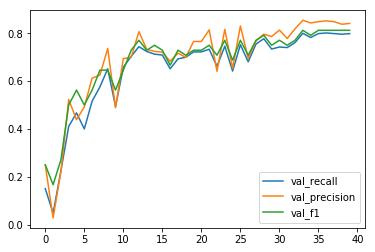

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

##BiRNN-CNN

In [0]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(6, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
mtrix=Metrics()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,metrics=[categorical_accuracy])
print "CNN, Word Embeddings",  accuracy

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

##KAGGLE CNN

In [0]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 151
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 300
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 300
# dropout probability
drop = 0.5
batch_size = 30
epochs = 2

In [0]:
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D,Lambda
from keras.backend import expand_dims
from keras.optimizers import Adam


def create_cnn_kaggle():

  inputs = Input((MAX_SEQUENCE_LENGTH, ))
  print(inputs.shape)
  embedding = Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=True)(inputs)

  print(embedding.shape)
  reshape = Lambda(lambda x: expand_dims(x, -1))(embedding)
  print(reshape.shape)

  conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

  maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
  maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)
  print(maxpool_1.shape)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(drop)(flatten)
  output = Dense(6, activation='sigmoid')(dropout)

  # this creates a model that includes
  model = models.Model(inputs=inputs, outputs=output)

  #checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto')
  adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[categorical_accuracy])
  
  return model



In [0]:
classifier = create_cnn_kaggle()
classifier.summary()
mtrix=Metrix()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=50,print_pred=False,one_hot=True)
print("CNN, Word Embeddings",  accuracy)

(?, 151)
(?, 151, 300)
(?, 151, 300, 1)
(?, 1, 1, 512)
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 151)          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 151, 300)     2094900     input_27[0][0]                   
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 151, 300, 1)  0           embedding_26[0][0]               
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 149, 1, 512)  461312      lambda_10[0][0]                  
____________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


384/384 [==============================] - 1s 3ms/step - loss: 0.5301 - categorical_accuracy: 0.2005 - val_loss: 0.4597 - val_categorical_accuracy: 0.3958
Epoch 3/50
384/384 [==============================] - 1s 3ms/step - loss: 0.4812 - categorical_accuracy: 0.3177 - val_loss: 0.4345 - val_categorical_accuracy: 0.5208
Epoch 4/50
384/384 [==============================] - 1s 3ms/step - loss: 0.4241 - categorical_accuracy: 0.4115 - val_loss: 0.4027 - val_categorical_accuracy: 0.6458
Epoch 5/50
384/384 [==============================] - 1s 3ms/step - loss: 0.3912 - categorical_accuracy: 0.4714 - val_loss: 0.3812 - val_categorical_accuracy: 0.6875
Epoch 6/50
384/384 [==============================] - 1s 3ms/step - loss: 0.3483 - categorical_accuracy: 0.5234 - val_loss: 0.3741 - val_categorical_accuracy: 0.7292
Epoch 7/50
384/384 [==============================] - 1s 3ms/step - loss: 0.3235 - categorical_accuracy: 0.6276 - val_loss: 0.3660 - val_categorical_accuracy: 0.7500
Epoch 8/50
384/

In [0]:
train_seq_x.shape

(384, 151)

In [0]:
%pdb

Automatic pdb calling has been turned OFF


##BI-LSTM with Attention

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout


def BidLstm(maxlen, max_features, embed_size, embedding_matrix):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = LSTM(300, return_sequences=True, dropout=0.15,
                           recurrent_dropout=0.15)(x)
    x = Attention(maxlen)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=[categorical_accuracy])
    return model

In [0]:
classifier = BidLstm(144,len(word_index) + 1,300,embedding_matrix)
classifier.summary()
mtrix=Metrix()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True,epochs=30,print_pred=False,one_hot=True)
print("CNN, Word Embeddings",  accuracy)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 144)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 144, 300)          2094900   
_________________________________________________________________
lstm_8 (LSTM)                (None, 144, 300)          721200    
_________________________________________________________________
attention_8 (Attention)      (None, 300)               444       
_________________________________________________________________
dense_36 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 774

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 2/30
384/384 [==============================] - 4s 11ms/step - loss: 0.4139 - categorical_accuracy: 0.4844 - val_loss: 0.3521 - val_categorical_accuracy: 0.5417
Epoch 3/30
384/384 [==============================] - 4s 11ms/step - loss: 0.3113 - categorical_accuracy: 0.6146 - val_loss: 0.3036 - val_categorical_accuracy: 0.6667
Epoch 4/30
384/384 [==============================] - 4s 11ms/step - loss: 0.2551 - categorical_accuracy: 0.6667 - val_loss: 0.2324 - val_categorical_accuracy: 0.7083
Epoch 5/30
384/384 [==============================] - 4s 11ms/step - loss: 0.1882 - categorical_accuracy: 0.7865 - val_loss: 0.2097 - val_categorical_accuracy: 0.7292
Epoch 6/30
384/384 [==============================] - 4s 11ms/step - loss: 0.1651 - categorical_accuracy: 0.8490 - val_loss: 0.2023 - val_categorical_accuracy: 0.8333
Epoch 7/30
384/384 [==============================] - 4s 11ms/step - loss: 0.1219 - categorical_accuracy: 0.8750 - val_loss: 0.2037 - val_categorical_accuracy: 0.833

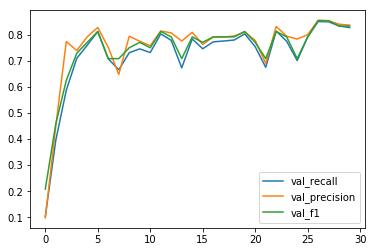

In [0]:
from matplotlib import pyplot as plt
val_f1=[]
val_precision=[]
val_recall=[]
for i in mtrix.get_data():
  val_f1.append(i['val_f1'])
  val_precision.append(i['val_precision'])
  val_recall.append(i['val_recall'])

plt.plot(val_f1)
plt.plot(val_precision)
plt.plot(val_recall)
plt.legend(i.keys())

In [0]:
val_f1

[0.048484848484848485,
 0.1895424836601307,
 0.3603522913867742,
 0.3332144979203803,
 0.6512697184136812,
 0.7574074074074074,
 0.7174714690194567,
 0.6975412387177093,
 0.7146284514705568,
 0.758840288252053,
 0.7048350041771094,
 0.7821428571428571,
 0.7977582846003899,
 0.8292397660818712,
 0.7821428571428571,
 0.7565359477124183,
 0.725925925925926,
 0.7923669467787114,
 0.8062678062678063,
 0.7942110177404295,
 0.806730469965764,
 0.8062678062678063,
 0.7346863891755532,
 0.727817910790047,
 0.6847265221878226,
 0.8345782757547463,
 0.6900161030595813,
 0.6935185185185185,
 0.7666789522826676,
 0.8496762740183793]

In [0]:
np.max(val_f1)

0.8505291005291006